# This is Jake's Data Challenge 1 Solution.

In [123]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# load in data
df = pd.read_csv('employee_retention_data.csv')
print df.shape
df.head()

(24702, 7)


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


OK, the first task is to make a table with day, employee headcount and company id.
I'm going to make this as a pandas dataframe so that it doesn't need to run a SQL db in the repository version.
It probably ought to be ordered by day, so how to do this?
There are 12 companies (1 to 12).  

In [3]:
# so step 1, convert join_date and quit_date to datetimes and convert them to days since the first day:
df.loc[:,'quit_date'] = pd.to_datetime(df.loc[:,'quit_date'], format='%Y-%m-%d')
df.loc[:,'join_date'] = pd.to_datetime(df.loc[:,'join_date'], format='%Y-%m-%d')
df['join_day'] = (df['join_date']-min(df['join_date'])).apply(lambda x: x.days)
df['quit_day'] = (df['quit_date']-min(df['join_date'])).apply(lambda x: x.days)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_day,quit_day
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1155,1740.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,826,1166.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,1358,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,476,865.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,266,1306.0


In [4]:
#step 2 would be to just make the table

column_id=['day','company_id','employees']
table2 = pd.DataFrame(columns = column_id)
init_day = min(df['join_day'])
for j in df['company_id'].unique():
    joined_today = ((df['company_id']==j)&(df['join_day']==init_day)).sum()
    temp = np.array([[init_day],[j],[joined_today]]).T
    temp=pd.DataFrame(temp,columns=column_id,)
    table2 = table2.append(temp, ignore_index = True)

for i in range (1, max(df['join_day'])):
    for j in df['company_id'].unique():
        joined_today = ((df['company_id']==j)&(df['join_day']==i)).sum()
        left_today = ((df['company_id']==j)&(df['quit_day']==i)).sum()
        employees_prev = int(table2[(table2['day']==(i-1))&(table2['company_id']==j)]['employees'])
        employees_today = employees_prev+joined_today-left_today
        temp = np.array([[i],[j],[employees_today]]).T
        temp = pd.DataFrame(temp, columns = column_id)
        table2 = table2.append(temp, ignore_index = True)

table2

,day,company_id,employees
0,0,7,1
1,0,4,12
2,0,2,17
3,0,9,3
4,0,1,25
5,0,6,3
6,0,10,0
7,0,5,5
8,0,3,9
9,0,8,6


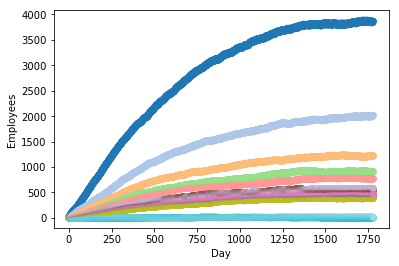

In [147]:
plt.scatter(x=table2['day'],y=table2['employees'], c=table2['company_id'], cmap = cm.tab20)
plt.xlabel('Day')
plt.ylabel('Employees')

OK, I take "employee churn" to mean the rate at which employees leave.
I would think this is more intersting to the company as inverse employee tenure, rather than delta n_employees / time
That's what I'll define churn as.
I want to do a multivariate linear regressions on churn for each company, looking at a few different variables:
N_employees at start, N_employees at end, pay, seniority, rate of rate of N/employees over duration of tenure.
There's also the dept, but I don't have time to figure out how to do a linear regression with categorical data.

So let's make that table: 

In [7]:
# to df, let's add columns for 1/tenure, n_employees at start date, n_employees at the date & company growth rate
df = df[pd.notnull(df['quit_day'])]
df.head()


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_day,quit_day
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1155,1740.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,826,1166.0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,476,865.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,266,1306.0
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,371,949.0


In [33]:
# calculate and add columns for employees at start and employees at end
empl_start = []
empl_end = []
for index, row in df.iterrows():
    empl_start.append(int(table2[(table2['day']==row['join_day'])&(table2['company_id']==row['company_id'])]['employees']))
    empl_end.append(int(table2[(table2['day']==row['quit_day'])&(table2['company_id']==row['company_id'])]['employees']))

df['empl_start'] = 0
df['empl_end'] = 0
df['empl_start']=empl_start
df['empl_end']=empl_end

In [49]:
# calculate and add column for employee growth over the course of the employee's tenrure
df['empl_growth_rate'] = 0
growth = []
for index, row in df.iterrows():
    growth.append(float((row['empl_end']-row['empl_start'])/(row['quit_day']-row['join_day'])))

df['empl_growth_rate'] = growth

# calculate employee "churn" = 1/tenure
df['churn'] = df.apply(lambda x: float(1/(x['quit_day']-x['join_day'])), axis=1)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_day,quit_day,empl_start,empl_end,empl_growth_rate,churn
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1155,1740.0,522,532,0.017094,0.001709
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,826,1166.0,467,523,0.164706,0.002941
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,476,865.0,302,468,0.426735,0.002571
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,266,1306.0,615,1855,1.192308,0.000962
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,371,949.0,431,747,0.546713,0.001730


OK, now let's do a bunch of linear regressions:

In [126]:
coefs = []
model = linear_model.LinearRegression()
scaler = StandardScaler()
# x_scaled = scaler.fit_transform(x)
for j in df['company_id'].unique():
    y = df[df['company_id']==j]['churn'].reshape(-1,1)
    y = scaler.fit_transform(y)
    x= df[df['company_id']==j][['salary','seniority','empl_start','empl_end','empl_growth_rate']].values.reshape(-1,5)
    x = scaler.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
    model.fit(x_train,y_train)
    coefs.append([(model.coef_[0])])
    print 'Score of company_id',j,'is : ',model.score(x_test, y_test),' & intercept is: ',model.intercept_

np.set_printoptions(precision=4)
coefs

Score of company_id 7 is :  0.575841930058  & intercept is:  [-0.0282]
Score of company_id 2 is :  0.772127313104  & intercept is:  [-0.0036]
Score of company_id 4 is :  0.739459754859  & intercept is:  [-0.0055]
Score of company_id 9 is :  0.752299299282  & intercept is:  [ 0.0065]
Score of company_id 6 is :  0.743224938979  & intercept is:  [-0.0008]
Score of company_id 1 is :  0.751212690892  & intercept is:  [-0.0025]
Score of company_id 10 is :  0.721454602764  & intercept is:  [-0.0137]
Score of company_id 5 is :  0.770417724966  & intercept is:  [-0.0036]
Score of company_id 3 is :  0.76428132062  & intercept is:  [-0.0006]
Score of company_id 8 is :  0.749459413045  & intercept is:  [ 0.0111]
Score of company_id 11 is :  -23.1462047419  & intercept is:  [ 0.146]
Score of company_id 12 is :  -56.8608994914  & intercept is:  [-0.0515]


/Users/jakesiegel/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


[[array([-0.0404,  0.0253,  1.3496, -0.5872,  0.763 ])],
 [array([-0.006 , -0.0046,  0.718 , -1.2311, -0.4648])],
 [array([ 0.002 ,  0.0046,  1.267 , -0.7987,  0.4531])],
 [array([-0.0102,  0.0022,  1.1289, -0.8855,  0.28  ])],
 [array([-0.0012,  0.0306,  1.1012, -0.9786,  0.1701])],
 [array([ 0.0043, -0.0146,  1.1202, -0.8805,  0.2384])],
 [array([-0.0286,  0.0162,  1.2376, -0.804 ,  0.4247])],
 [array([-0.0259,  0.0342,  1.2523, -0.7593,  0.4627])],
 [array([-0.015 , -0.0057,  0.9447, -1.1192, -0.1373])],
 [array([-0.0646,  0.0544,  1.2559, -0.8487,  0.3821])],
 [array([-0.8395, -0.5139,  2.1154, -0.3478,  1.8858])],
 [array([-0.2237, -0.1037,  2.3488, -2.1003,  1.2557])]]

# Report:
About 3/4 of the variation can be accounted for by the fit.  It looks as though the strongest correlated variable for high churn is the number of employees at the time of the employee joining the company.  The next strongest seems to be the growth of the company.  I think company size probably makes sense, but I'm surprised it's not more strongly correlated at the end.  It would probably make sense to look at the flux of employees as a driving factor rather than the growth rate.

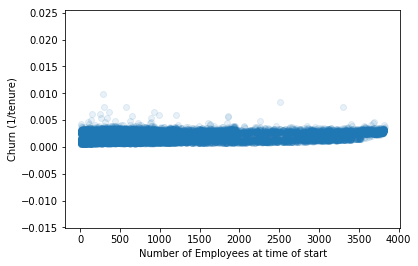

In [144]:
plt.scatter(df['empl_start'], df['churn'], alpha = 0.1)
plt.xlabel('Number of Employees at time of start')
plt.ylabel('Churn (1/tenure)')

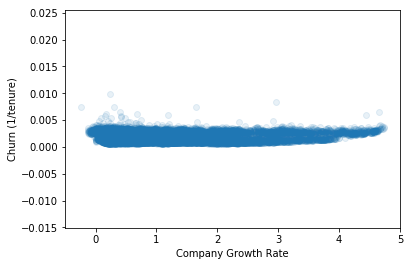

In [146]:
plt.scatter(df['empl_growth_rate'], df['churn'],alpha = 0.1)
plt.xlabel('Company Growth Rate')
plt.ylabel('Churn (1/tenure)')

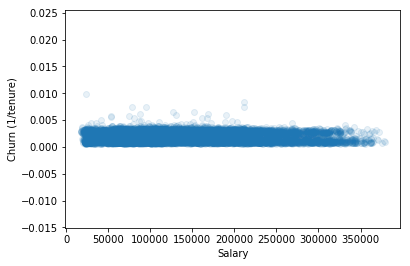

In [145]:
plt.scatter(df['salary'], df['churn'],alpha = 0.1)
plt.xlabel('Salary')
plt.ylabel('Churn (1/tenure)')